Author: Andreas Traut   
Basis for this notebook are various tutorials which I found on the internet and documentation from Tensorflow.   
Date: 11.09.2020

In this notebook the data will be loaded, the model will be designed, optimized, trained, evaluated and saved. 

**Here I use _"cifar100"_ instead of _"cifar10"_ !**  

We will see that with the same model the accuracy will drop from over 80% to about 50%. 

# Import the libaries

In [1]:
import numpy 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import constraints 
from tensorflow.keras import utils

In [2]:
seed = 21

# Load and prepare the data

Now we will use cifar100 instead of cifar10. We will see that with the same model the accuracy will drop from over 80% to about 50%. 

In [3]:
from tensorflow.keras.datasets import cifar100

In [4]:
(X_train, y_train_raw), (X_test, y_test_raw) = cifar100.load_data(label_mode="fine")

In [5]:
# normalize the inputs from 0-255 to between 0 and 1 by dividing by 255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
# one hot encode outputs
y_train = utils.to_categorical(y_train_raw)
y_test = utils.to_categorical(y_test_raw)
class_num = y_test.shape[1]

In [7]:
X_train.shape

(50000, 32, 32, 3)

In [8]:
X_test.shape

(10000, 32, 32, 3)

In [9]:
y_train_raw

array([[19],
       [29],
       [ 0],
       ...,
       [ 3],
       [ 7],
       [73]])

In [10]:
label = [
'apple', # id 0
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]

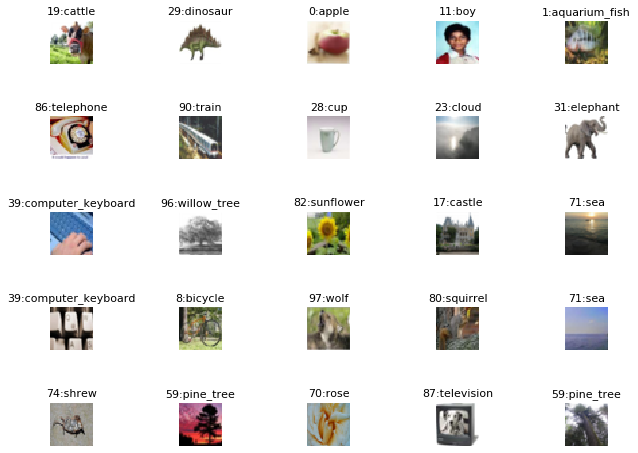

In [13]:
plt.figure(figsize=(10, 8))
n_rows, n_cols = 5, 5
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        t = str(y_train_raw[i][0]) + ":" + label[y_train_raw[i][0]]
        plt.title(t, fontsize=11)
        plt.subplots_adjust(wspace=2., hspace=0.8)
        plt.axis("off")        
        plt.imshow(X_train[i])

# Design the model

In [8]:
model = Sequential()

The first layer is a convolutional layer. We specify 32 filters (size of each filter is 3x3). 

Activation is "relu". 

Dont change the size of the image: Padding='same' 

In [9]:
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))

In order to prevent overfitting we randomly put 20% or the connections to zero: 

In [10]:
model.add(Dropout(0.2))

Batch Normalization normalizes the inputs heading into the next layer, ensuring that the network always creates activations with the same distribution that we desire:

In [11]:
model.add(BatchNormalization())

Now comes another convolutional layer, but the filter size increases so the network can learn more complex representations:

In [12]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

Pooling layer: helps make the image classifier more robust. It's important not to have too many pooling layers, as each pooling discards some data. Pooling too often will lead to there being almost nothing for the densely connected layers to learn about when the data reaches them.

Plus dropout and BatchNormalization. 

In [13]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

Now repeat this: 

In [14]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
    
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

Now we need to Flatten the data:


In [15]:
model.add(Flatten())
model.add(Dropout(0.2))

Now create densely connected layer. 
The kernel constraint can regularize the data as it learns, another thing that helps prevent overfitting.

In [16]:
model.add(Dense(256, kernel_constraint=constraints.MaxNorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
    
model.add(Dense(128, kernel_constraint=constraints.MaxNorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

Finally, the softmax activation function selects the neuron with the highest probability as its output, voting that the image belongs to that class:

In [17]:
model.add(Dense(class_num))
model.add(Activation('softmax'))

# Optimize the model

Now that we've designed the model we want to use, we just have to compile it. Let's specify the number of epochs we want to train for, as well as the optimizer we want to use.

In [18]:
epochs = 25
optimizer = 'adam'

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [20]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 28)        784       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 28)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 28)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 28)        112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        16192     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0

# Train the model and use Tensorboard

In [ ]:
%load_ext tensorboard
#  %reload_ext tensorboard

In [ ]:
import datetime
from tensorflow.keras import callbacks 

In [21]:
numpy.random.seed(seed)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64, callbacks=[tensorboard_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 128s 3ms/sample - loss: 3.8626 - accuracy: 0.1183 - val_loss: 3.4029 - val_accuracy: 0.1935
Epoch 2/25
50000/50000 [==============================] - 127s 3ms/sample - loss: 3.1890 - accuracy: 0.2219 - val_loss: 2.8790 - val_accuracy: 0.2777
Epoch 3/25
50000/50000 [==============================] - 134s 3ms/sample - loss: 2.7891 - accuracy: 0.2921 - val_loss: 2.4534 - val_accuracy: 0.3627
Epoch 4/25
50000/50000 [==============================] - 134s 3ms/sample - loss: 2.5334 - accuracy: 0.3444 - val_loss: 2.2926 - val_accuracy: 0.3979
Epoch 5/25
50000/50000 [==============================] - 132s 3ms/sample - loss: 2.3716 - accuracy: 0.3777 - val_loss: 2.2542 - val_accuracy: 0.4097
Epoch 6/25
50000/50000 [==============================] - 132s 3ms/sample - loss: 2.2487 - accuracy: 0.4042 - val_loss: 2.1072 - val_accuracy: 0.4469
Epoch 7/25
50000/50000 [==========================

To plot the learning curve:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [ ]:
plot_learning_curves(history)

In [ ]:
%tensorboard --logdir logs/fit

# Evaluate model

In [22]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 52.77%


# Save Model

In [24]:
model.save('saved_model\my_model_cifar100') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model_cifar100\assets


In [ ]:
import tensorflow as tf 
new_model = tf.keras.models.load_model('saved_model\my_model_cifar100')